In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [3]:
def show_image_mosaic(imgs, labels, figsize=(12, 12), idxs=None):

    plt.figure(figsize=figsize)
    for labi,lab in [i for i in enumerate(np.unique(labels))]:
        k = imgs[labels == lab]
        _idxs = idxs[:10] if idxs is not None else np.random.permutation(len(k))[:10]
        for i, idx in enumerate(_idxs):
            if i == 0:
                plt.subplot(10, 11, labi*11+1)
                plt.title("LABEL %d" % lab)
                plt.plot(0, 0)
                plt.axis("off")

            img = k[idx]
            plt.subplot(10, 11, labi*11+i+2)
            plt.imshow(img, cmap=plt.cm.Greys_r)
            plt.axis("off")

In [4]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

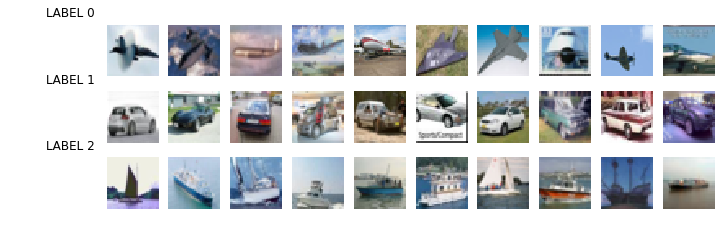

In [5]:
show_image_mosaic(x_cifar, y_cifar)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print ("\ndistribution of train classes")
print (pd.Series(y_train).value_counts())
print ("\ndistribution of test classes")
print (pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    770
0    743
1    740
dtype: int64

distribution of test classes
0    262
2    255
1    234
dtype: int64


## preprocesado de imágenes

realizamos ahora una transformación sencilla sobre las imágenes usando las herramientas de TF

In [8]:
timgs = tf.placeholder(dtype=tf.float32, shape=(None, 32,32,3))
cimgs = tf.image.adjust_contrast(timgs, 10.)

with tf.Session() as sess:
    cx_train = sess.run(cimgs, feed_dict={timgs: x_train})
    cx_test  = sess.run(cimgs, feed_dict={timgs: x_test})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

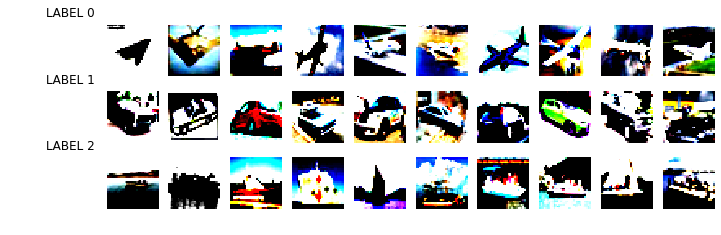

In [12]:
import warnings
warnings.simplefilter("ignore")
show_image_mosaic(cx_train, y_train)

fíjate en el impacto en la predicción 

In [15]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.8)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [16]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_A(num_classes)

using 3 classes


In [17]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(cx_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(cx_test, y_test))
    metrics = model.evaluate(cx_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [18]:
model = get_conv_model_A(num_classes)
model.summary()
train(model, batch_size=32, epochs=10, model_name="model_A")

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 15)        420       
_________________________________________________________________
flatten (Flatten)            (None, 13500)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                216016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output_1 (Dense)             (None, 3)                 51        
Total params: 216,487
Trainable params: 216,487
Non-trainable params: 0
______________________________________________________

{'loss': 1.0984347231696037, 'acc': 0.33954728}